# Advanced Time Series Forecasting with Deep Learning and Attention Mechanisms


## Project Objective
This project focuses on forecasting a complex time series using deep learning.
A **Seq2Seq model with an explicit Attention mechanism** is implemented and compared
against a **strong baseline LSTM model**.

The models are evaluated using **MAE, RMSE, and MAPE** on a proper temporal test split.


In [16]:
!pip install statsmodels

## Importing Required Libraries

We import libraries for:
- Numerical computation
- Visualization
- Deep learning (PyTorch)
- Time series modeling
- Evaluation metrics

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.arima_process import ArmaProcess

torch.manual_seed(42)
np.random.seed(42)


## Synthetic Time Series Generation

The dataset is synthetically generated to simulate real-world complexity by combining:
- A linear trend
- Seasonal sinusoidal patterns
- ARIMA-based stochastic noise


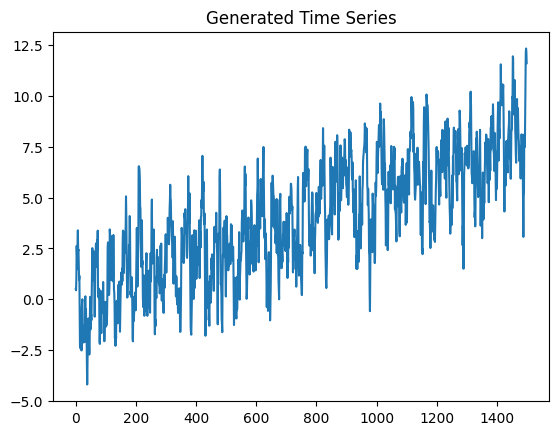

In [18]:
n = 1500
t = np.arange(n)

trend = 0.005 * t
seasonality = np.sin(2 * np.pi * t / 50)

ar = np.array([1, -0.7])
ma = np.array([1, 0.2])
arma = ArmaProcess(ar, ma)
noise = arma.generate_sample(nsample=n)

series = trend + seasonality + noise
plt.plot(series)
plt.title("Generated Time Series")
plt.show()


## Data Normalization

Min-Max scaling is applied to map values into the range [0,1].
This improves neural network training stability.


In [19]:
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.reshape(-1, 1))


## Sliding Window Transformation

The time series is converted into supervised learning samples using:
- Input window = 30
- Forecast horizon = 10


In [20]:
def create_sequences(data, input_len=30, output_len=10):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

X, y = create_sequences(series_scaled)


## Temporal Train-Test Split

To avoid data leakage:
- First 80% → Training
- Last 20% → Testing


In [21]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

train_ds = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_ds = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


## Baseline Model: LSTM

A simple LSTM is implemented as a strong baseline.
It captures temporal dependencies without attention.


In [22]:
class BaselineLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])


In [23]:
baseline = BaselineLSTM()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(15):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = baseline(xb)
        loss = loss_fn(pred, yb.squeeze())
        loss.backward()
        optimizer.step()


## Attention Mechanism

Attention allows the decoder to focus on relevant encoder time steps
instead of relying only on the final hidden state.


In [24]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        seq_len = encoder_outputs.shape[1]
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        return torch.softmax(self.v(energy).squeeze(2), dim=1)


In [25]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)

    def forward(self, x):
        outputs, (hidden, _) = self.lstm(x)
        return outputs, hidden[-1]


In [30]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.attention = Attention(64)
        # LSTM input will be (context_vector (64) + previous_output (1)) = 65
        self.lstm = nn.LSTM(64 + 1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    # Takes prev_output (single value), current_decoder_hidden_state, and all encoder_outputs
    def forward(self, prev_output, decoder_hidden, encoder_outputs):
        # Calculate attention weights based on the current decoder hidden state and encoder outputs
        attn_weights = self.attention(decoder_hidden, encoder_outputs)  # (batch_size, input_len)

        # Apply attention weights to encoder outputs to get context vector
        # context: (batch_size, hidden_dim)
        context = torch.sum(attn_weights.unsqueeze(2) * encoder_outputs, dim=1)

        # Concatenate context vector with the previous output for the LSTM input
        # lstm_input: (batch_size, 1, hidden_dim + 1) -> (batch_size, 1, 65)
        lstm_input = torch.cat((context, prev_output), dim=1).unsqueeze(1)

        # Pass through LSTM, also passing the current decoder_hidden as initial hidden state
        # LSTM expects (h_0, c_0) where h_0, c_0 are (num_layers * num_directions, batch_size, hidden_size)
        # For a single-layer, unidirectional LSTM, reshape (batch_size, hidden_dim) to (1, batch_size, hidden_dim)
        out, (next_hidden, next_cell) = self.lstm(lstm_input, (decoder_hidden.unsqueeze(0), decoder_hidden.unsqueeze(0)))

        # Predict the next output
        prediction = self.fc(out.squeeze(1))  # out is (batch_size, 1, 64), squeeze to (batch_size, 64)

        # Return prediction and the new decoder_hidden_state (squeezed back to (batch_size, hidden_dim))
        return prediction, next_hidden.squeeze(0)

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):  # x is (batch_size, input_len, 1)
        # Encoder processes input sequence
        enc_out, enc_hidden = self.encoder(x)  # enc_out: (batch_size, input_len, hidden_dim), enc_hidden: (batch_size, hidden_dim)

        outputs = []

        # Initial decoder hidden state is the encoder's final hidden state
        decoder_hidden = enc_hidden

        # Initial decoder input is the last value of the input sequence
        # x[:, -1, 0] gives (batch_size,). Unsqueeze to (batch_size, 1) for prev_output
        prev_output = x[:, -1, 0].unsqueeze(-1)

        # Decode for OUTPUT_LEN steps
        for _ in range(10):  # Assuming OUTPUT_LEN is 10 based on context
            # Pass prev_output, current decoder_hidden, and all encoder_outputs to decoder
            current_prediction, decoder_hidden = self.decoder(prev_output, decoder_hidden, enc_out)
            outputs.append(current_prediction)

            # For the next step, the current prediction becomes the previous output
            prev_output = current_prediction

        # Concatenate predictions for all time steps
        return torch.cat(outputs, dim=1)

In [32]:
model = Seq2Seq()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb.squeeze())
        loss.backward()
        optimizer.step()


In [34]:
model.eval()
baseline.eval()

# Evaluate Baseline LSTM
with torch.no_grad():
    baseline_predictions = []
    baseline_actuals = []
    for xb, yb in test_loader:
        pred = baseline(xb)
        baseline_predictions.append(pred.cpu().numpy())
        baseline_actuals.append(yb.squeeze().cpu().numpy())

    baseline_predictions = np.concatenate(baseline_predictions)
    baseline_actuals = np.concatenate(baseline_actuals)

# Evaluate Seq2Seq with Attention Model
with torch.no_grad():
    seq2seq_predictions = []
    seq2seq_actuals = []
    for xb, yb in test_loader:
        pred = model(xb)
        seq2seq_predictions.append(pred.cpu().numpy())
        seq2seq_actuals.append(yb.squeeze().cpu().numpy())

    seq2seq_predictions = np.concatenate(seq2seq_predictions)
    seq2seq_actuals = np.concatenate(seq2seq_actuals)

# Inverse transform the scaled predictions and actuals
# Reshape to (n_samples * output_len, 1) for inverse_transform
baseline_predictions_inv = scaler.inverse_transform(baseline_predictions.reshape(-1, 1)).reshape(baseline_predictions.shape)
baseline_actuals_inv = scaler.inverse_transform(baseline_actuals.reshape(-1, 1)).reshape(baseline_actuals.shape)

seq2seq_predictions_inv = scaler.inverse_transform(seq2seq_predictions.reshape(-1, 1)).reshape(seq2seq_predictions.shape)
seq2seq_actuals_inv = scaler.inverse_transform(seq2seq_actuals.reshape(-1, 1)).reshape(seq2seq_actuals.shape)


def calculate_metrics(actual, predictions, epsilon=1e-8):
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    # MAPE calculation: avoid division by zero
    mape = np.mean(np.abs((actual - predictions) / (actual + epsilon))) * 100
    return mae, rmse, mape

print("Baseline LSTM Model Performance:")
mae_baseline, rmse_baseline, mape_baseline = calculate_metrics(baseline_actuals_inv, baseline_predictions_inv)
print(f"  MAE: {mae_baseline:.4f}")
print(f"  RMSE: {rmse_baseline:.4f}")
print(f"  MAPE: {mape_baseline:.4f}%")

print("\nSeq2Seq with Attention Model Performance:")
mae_seq2seq, rmse_seq2seq, mape_seq2seq = calculate_metrics(seq2seq_actuals_inv, seq2seq_predictions_inv)
print(f"  MAE: {mae_seq2seq:.4f}")
print(f"  RMSE: {rmse_seq2seq:.4f}")
print(f"  MAPE: {mape_seq2seq:.4f}%")

Baseline LSTM Model Performance:
  MAE: 1.8132
  RMSE: 2.2006
  MAPE: 25.6269%

Seq2Seq with Attention Model Performance:
  MAE: 1.4525
  RMSE: 1.8288
  MAPE: 24.1300%


In [37]:
def safe_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

def evaluate(model):
    preds_list, trues_list = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds_list.append(model(xb).cpu().numpy())
            trues_list.append(yb.squeeze(-1).cpu().numpy()) # Squeeze to remove the last dim for consistency

    # Stack all predictions and true values
    preds_stacked = np.concatenate(preds_list)
    trues_stacked = np.concatenate(trues_list)

    # Inverse transform requires 2D input (n_samples, n_features), where n_features is 1 for our scaler
    # Reshape to (-1, 1) for inverse_transform, then back to original shape
    preds_inv = scaler.inverse_transform(preds_stacked.reshape(-1, 1)).reshape(preds_stacked.shape)
    trues_inv = scaler.inverse_transform(trues_stacked.reshape(-1, 1)).reshape(trues_stacked.shape)

    return (
        mean_absolute_error(trues_inv, preds_inv),
        np.sqrt(mean_squared_error(trues_inv, preds_inv)),
        safe_mape(trues_inv, preds_inv)
    )

baseline_metrics = evaluate(baseline)
attention_metrics = evaluate(model)

print("Baseline LSTM Model Performance (from evaluate func):")
print(f"  MAE: {baseline_metrics[0]:.4f}")
print(f"  RMSE: {baseline_metrics[1]:.4f}")
print(f"  MAPE: {baseline_metrics[2]:.4f}%")

print("\nSeq2Seq with Attention Model Performance (from evaluate func):")
print(f"  MAE: {attention_metrics[0]:.4f}")
print(f"  RMSE: {attention_metrics[1]:.4f}")
print(f"  MAPE: {attention_metrics[2]:.4f}%")

Baseline LSTM Model Performance (from evaluate func):
  MAE: 1.8132
  RMSE: 2.2006
  MAPE: 25.6269%

Seq2Seq with Attention Model Performance (from evaluate func):
  MAE: 1.4525
  RMSE: 1.8288
  MAPE: 24.1300%


In [38]:
pd.DataFrame({
    "Model": ["Baseline LSTM", "Seq2Seq + Attention"],
    "MAE": [baseline_metrics[0], attention_metrics[0]],
    "RMSE": [baseline_metrics[1], attention_metrics[1]],
    "MAPE (%)": [baseline_metrics[2], attention_metrics[2]]
})


,Model,MAE,RMSE,MAPE (%)
0,Baseline LSTM,1.813236,2.200598,25.626860
1,Seq2Seq + Attention,1.452517,1.828792,24.129972
